In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D

%matplotlib inline

print(tf.__version__)
print(tf.keras.__version__)

2.0.0
2.2.4-tf


## Load data and preprocess data

In [2]:
def load_data():
    mnist_dataset = tf.keras.datasets.mnist.load_data()
    (x_train, y_train), (x_test, y_test) = mnist_dataset
    
    ### Preprocess the data
    # normalization
    # scale pixel value from 0:255 to 0:1
    x_train = x_train / 255.0
    x_test = x_test / 255.0

    # Add a channels dimension
    x_train = x_train[..., tf.newaxis]
    x_test = x_test[..., tf.newaxis]
    
    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_data()

print("Training images: ", x_train.shape)
print("Training lables: ", y_train.shape)
print("Testing images: ", x_test.shape)
print("Testing labels: ", y_test.shape)
print("data type: ", type(x_train))

Training images:  (60000, 28, 28, 1)
Training lables:  (60000,)
Testing images:  (10000, 28, 28, 1)
Testing labels:  (10000,)
data type:  <class 'numpy.ndarray'>


## Visualize the data

- [matplotlib.pyplot.imshow](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.imshow.html)

    - Arguments:
    ```
    X:  array-like or PIL image. 
          The image data. Supported array shapes are:

          (M, N): an image with scalar data. The data is visualized using a colormap.
          (M, N, 3): an image with RGB values (0-1 float or 0-255 int).
          (M, N, 4): an image with RGBA values (0-1 float or 0-255 int), i.e. including transparency.
        
          The first two dimensions (M, N) define the rows and columns of the image.
          Out-of-range RGB(A) values are clipped.
    ```

Label: 5


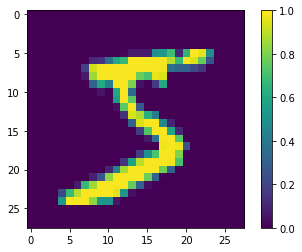

In [3]:
print("Label: {}".format(y_train[0]))

plt.figure()
plt.imshow(x_train[0].squeeze())
plt.colorbar()
plt.grid(False)

## Shuffle the dataset

[tf.data.Dataset](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/Dataset?hl=zh_tw)

- from_tensor_silces: Creates a `Dataset` whose elements are slices of the given tensors. 

    > Arguments:
    ```
    shuffle:  uses a fixed-size buffer to shuffle the items as they pass through. 
    repeat:   restarts the Dataset when it reachs the end.
                To limit the number of epochs, set the count argument.
    batch:    collects a number of examples and stacks them, to create batches.
    ```

In [4]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices(
    (x_test, y_test)).batch(32)

## Build the model

### Model subclassing

Create layers in the `__init__` method and set them as attributes of the class instance. Define the forward pass in the `call` method.
 
==> Like `PyTorch`.

In [5]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        
        # Define your layer here
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.dense1 = Dense(128, activation='relu')
        self.dense2 = Dense(10, activation='softmax')
    
    def call(self, x):
        # Define your forward pass here
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

model = MyModel()

### Compile the model

Before the model is ready for training, it needs a few more setting.

These are added during the model's `compile` step:

- Loss function
- Optimizer
- Metrics


In [6]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

## Training and testing the mode

Use [tf.GradientTape](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/GradientTape?hl=zh_tw)

In [7]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, predictions)

In [8]:
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [9]:
#tf.keras.backend.set_floatx('float64')

EPOCHS = 5

for epoch in range(EPOCHS):
    for images, labels in train_ds:
        train_step(images, labels)
    
    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result()*100,
                          test_loss.result(),
                          test_accuracy.result()*100))
    
    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()        

W1002 17:49:27.649177 139746901661504 base_layer.py:1814] Layer my_model is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Epoch 1, Loss: 0.1393195539712906, Accuracy: 95.80332946777344, Test Loss: 0.06004871428012848, Test Accuracy: 97.97999572753906
Epoch 2, Loss: 0.04322228580713272, Accuracy: 98.66166687011719, Test Loss: 0.05162382870912552, Test Accuracy: 98.3699951171875
Epoch 3, Loss: 0.023374395444989204, Accuracy: 99.23833465576172, Test Loss: 0.056067634373903275, Test Accuracy: 98.30999755859375
Epoch 4, Loss: 0.013499211519956589, Accuracy: 99.5433349609375, Test Loss: 0.05680181086063385, Test Accuracy: 98.4000015258789
Epoch 5, Loss: 0.010076966136693954, Accuracy: 99.65499877929688, Test Loss: 0.06585539877414703, Test Accuracy: 98.25
